In [1]:
import os, sys

%matplotlib widget 

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())

import matplotlib.pyplot as plt
import numpy as np

from src.solver_utils import solve_precond
from src.basis.basis import BasisHandler
from src.primitives import Primitives_MinimalSupport

In [2]:
#Benchamrk solution
u_exact = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
u_exact_x = lambda x, y: np.pi * np.cos(np.pi * x) * np.sin(np.pi * y)
u_exact_y = lambda x, y: np.pi * np.sin(np.pi * x) * np.cos(np.pi * y)
f_rhs = lambda x, y: 2 * (np.pi ** 2) * np.sin(np.pi * x) * np.sin(np.pi * y)

In [3]:
#Basis construction
primitives = Primitives_MinimalSupport()
basis_handler = BasisHandler(primitives=primitives, dimension=1)

In [4]:
def test_2d(
    levels,
    u_exact,
    u_exact_x,
    u_exact_y,
    f_rhs,
    xs_ref=np.linspace(0, 1, 100),
    ys_ref=np.linspace(0, 1, 100),
):
    """
    Run convergence study for the 2D Poisson wavelet–Galerkin solver (isotropic tensor).
    Uses only 1D bases and Kronecker structure (like the 1D test).
    """
    X, Y = np.meshgrid(xs_ref, ys_ref, indexing="ij")
    u_ref   = u_exact(X, Y)
    u_ref_x = u_exact_x(X, Y)
    u_ref_y = u_exact_y(X, Y)

    errors_L2, errors_H1, Ns, Ss, U_solutions = [], [], [], [], []

    for Jmax in levels:
        print(f"\n=== Testing level {Jmax} ===")

        # ---- build 1D bases ----
        basis_handler.build_basis(J_Max=Jmax, comp_call=True, J_0=2)
        basis_handler_diff = copy.deepcopy(basis_handler)
        basis_handler_diff.apply(differentiate, comp_call=True, axis=0)  # 1D derivative

        # ---- assemble 1D and 2D matrices ----
        M1 = assemble_matrix_integral_1d(
            basis_handler.flatten(), basis_handler.flatten()
        )
        S1 = assemble_matrix_integral_1d(
            basis_handler_diff.flatten(), basis_handler_diff.flatten()
        )
        from src.matrix_generation.matrix_generation import extend_stiffness
        S2 = extend_stiffness(M1, S1, 2)
        Ss.append(S2)

        # ---- project RHS (2D Gauss from the 1D basis) and solve ----
        b2 = basis_handler.project_rhs_2d_gauss(f_rhs)
        coeffs = solve_precond(S2, b2)  # length N^2
        N1 = len(basis_handler.flatten())
        C = coeffs.reshape(N1, N1)

        # ---- evaluate Φ and Φ' on reference grids (1D only) ----
        Phix    = basis_handler._eval_basis_on_nodes(basis_handler.flatten(), xs_ref)
        Phiy    = basis_handler._eval_basis_on_nodes(basis_handler.flatten(), ys_ref)
        Phix_dx = basis_handler._eval_basis_on_nodes(basis_handler_diff.flatten(), xs_ref)
        Phiy_dy = basis_handler._eval_basis_on_nodes(basis_handler_diff.flatten(), ys_ref)

        # ---- tensor evaluations ----
        u_num   = Phix    @ C @ Phiy.T
        u_num_x = Phix_dx @ C @ Phiy.T
        u_num_y = Phix    @ C @ Phiy_dy.T

        U_solutions.append(u_num)

        # ---- errors ----
        err_L2 = np.sqrt(np.trapezoid(np.trapezoid((u_num - u_ref)**2, ys_ref, axis=1), xs_ref))
        grad_err = (u_num_x - u_ref_x)**2 + (u_num_y - u_ref_y)**2
        err_H1 = np.sqrt(np.trapezoid(np.trapezoid(grad_err, ys_ref, axis=1), xs_ref))

        print(f"L2 error = {err_L2:.3e},   H1 error = {err_H1:.3e}")

        errors_L2.append(err_L2)
        errors_H1.append(err_H1)
        Ns.append(N1**2)

    return errors_H1, errors_L2, Ss, Ns, U_solutions
       

In [4]:
levels=[2,3,4]
errors_H1, errors_L2, Ss, Ns, U_solutions=test_2d(levels,u_exact,u_exact_x,u_exact_y,f_rhs,)

NameError: name 'test_2d' is not defined

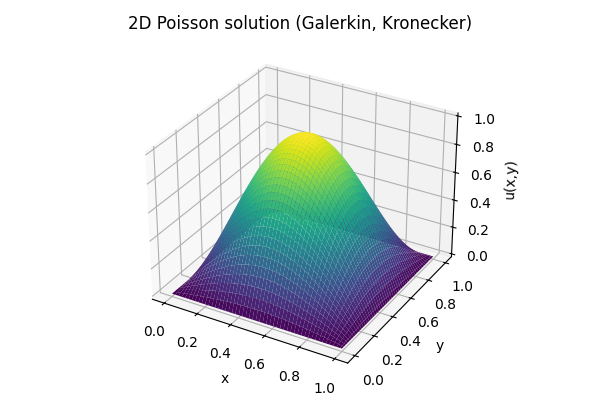

In [8]:
U_num=U_solutions[-1]
xs = np.linspace(0, 1, U_num.shape[0])
ys = np.linspace(0, 1, U_num.shape[1])
X, Y = np.meshgrid(xs, ys, indexing="ij")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, U_num, cmap="viridis", linewidth=0, antialiased=True)
ax.set_title("2D Poisson solution (Galerkin, Kronecker)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
plt.tight_layout()
plt.show()



Matrix size: 1024 × 1024
Condition number (original):      4.945e+02
Condition number (preconditioned): 2.688e+01
Original (after preconditioning): 204160 nonzeros  (19.47% dense)
Thresholded (|S| ≥ 1e-06): 190780 nonzeros  (18.19% dense)


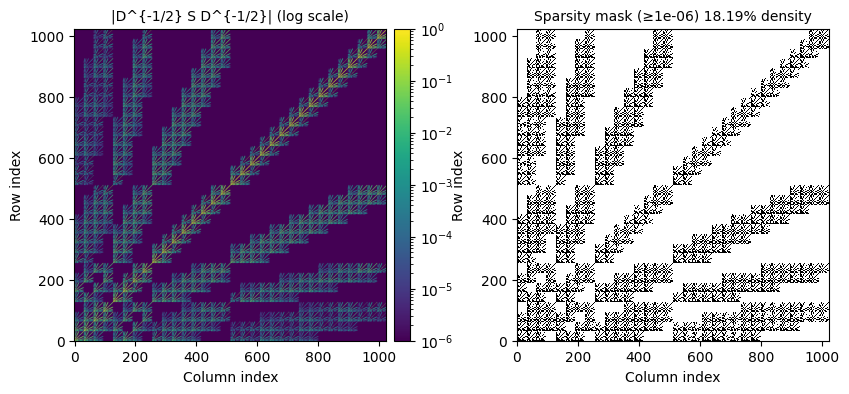

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --- Take last (finest) stiffness matrix ---
S_last = Ss[2]

# --- Precondition the matrix (D^{-1/2} S D^{-1/2}) ---
D = np.diag(np.diag(S_last))
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
S_precond = D_inv_sqrt @ S_last @ D_inv_sqrt

# --- Compute condition numbers ---
cond_orig = np.linalg.cond(S_last)
cond_precond = np.linalg.cond(S_precond)

print(f"Matrix size: {S_last.shape[0]} × {S_last.shape[1]}")
print(f"Condition number (original):      {cond_orig:.3e}")
print(f"Condition number (preconditioned): {cond_precond:.3e}")

# --- Threshold and sparsity stats ---
threshold = 1e-6
S_abs = np.abs(S_precond)  # visualize preconditioned version
S_mask = (S_abs >= threshold).astype(float)

n_total = S_abs.size
n_nz_orig = np.count_nonzero(S_abs)
n_nz_mask = np.count_nonzero(S_mask)
ratio_orig = 100 * n_nz_orig / n_total
ratio_mask = 100 * n_nz_mask / n_total

print(f"Original (after preconditioning): {n_nz_orig} nonzeros  ({ratio_orig:.2f}% dense)")
print(f"Thresholded (|S| ≥ {threshold:g}): {n_nz_mask} nonzeros  ({ratio_mask:.2f}% dense)")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# left: log-scaled preconditioned matrix
im0 = axes[0].imshow(
    S_abs + 1e-16,
    cmap="viridis",
    norm=LogNorm(vmin=np.max(S_abs) * 1e-6, vmax=np.max(S_abs)),
    origin="lower"
)
axes[0].set_title("|D^{-1/2} S D^{-1/2}| (log scale)", fontsize=10)
axes[0].set_xlabel("Column index")
axes[0].set_ylabel("Row index")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02)

# right: thresholded binary sparsity pattern
im1 = axes[1].imshow(S_mask, cmap="gray_r", origin="lower", interpolation="none")
axes[1].set_title(f"Sparsity mask (≥{threshold:g}) {ratio_mask:.2f}% density", fontsize=10)
axes[1].set_xlabel("Column index")
axes[1].set_ylabel("Row index")

# --- Adjust spacing to bring plots closer ---
plt.subplots_adjust(wspace=0.15, left=0.07, right=0.93, top=0.88, bottom=0.1)

plt.savefig("stiffness_poisson.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:


for S, J in zip(Ss, levels):
    # diagonal scaling
    # D = np.diag(np.diag(S))
    # D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    # S_precond = D_inv_sqrt @ S @ D_inv_sqrt

    # condition numbers
    # cond_orig = np.linalg.cond(S)
    # cond_pre = np.linalg.cond(S_precond)

    # print(f"Level J={J:<2d}:"
    #       f"cond(D^(-1/2) S D^(-1/2)) = {cond_pre:10.3e}")
    print(f"Level J={J:<2d}: nnz:{np.count_nonzero(S)} ")

Level J=2 : nnz:2704 
Level J=3 : nnz:26244 
Level J=4 : nnz:204160 
Level J=5 : nnz:1367960 
Level J=6 : nnz:8241052 


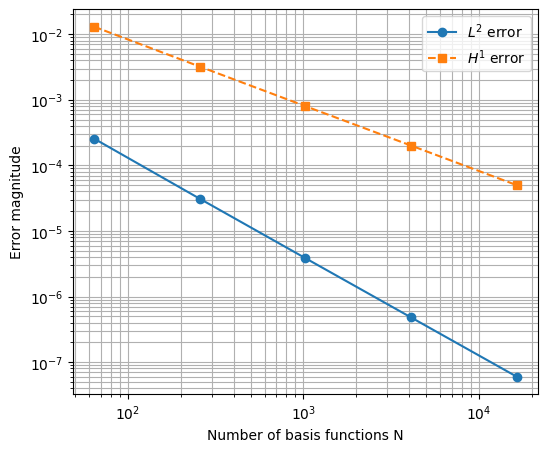

In [8]:
plt.figure(figsize=(6,5))
plt.loglog(Ns, errors_L2, 'o-', label=r'$L^2$ error')
plt.loglog(Ns, errors_H1, 's--', label=r'$H^1$ error')
plt.xlabel("Number of basis functions N")
plt.ylabel("Error magnitude")
plt.grid(True, which="both")
plt.legend()
plt.savefig("Poisson_convergence.png", dpi=300)
plt.show()

In [10]:
import numpy as np

# --- choose a non-homogeneous Dirichlet problem via lifting ---
# u = u_h + u_g, with u_g|_{∂Ω} = g and u_h|_{∂Ω} = 0
# Pick u_g(x,y) = x (harmonic), and u_h(x,y) = sin(pi x) sin(pi y)
# => u_exact = x + sin(pi x) sin(pi y)
# Poisson: -Δu = f  =>  f = -Δu_exact = 2*pi^2*sin(pi x)sin(pi y)

pi = np.pi

def u_g(x, y):         # lifting function (satisfies boundary data)
    return x

def lap_u_g(x, y):     # Δ u_g = 0 (harmonic)
    return 0.0 * x

def u_h_exact(x, y):
    return np.sin(pi*x) * np.sin(pi*y)

def u_h_exact_x(x, y):
    return pi * np.cos(pi*x) * np.sin(pi*y)

def u_h_exact_y(x, y):
    return pi * np.sin(pi*x) * np.cos(pi*y)

def u_exact(x, y):
    return u_g(x, y) + u_h_exact(x, y)

def u_exact_x(x, y):
    return 1.0 + u_h_exact_x(x, y)

def u_exact_y(x, y):
    return u_h_exact_y(x, y)

def f_rhs(x, y):       # RHS for the original (non-homog) problem
    return 2.0*(pi**2)*np.sin(pi*x)*np.sin(pi*y)

def f_eff(x, y):       # RHS for the homogeneous problem of u_h
    return f_rhs(x, y) + lap_u_g(x, y)  # = f - A u_g with A=-Δ  -> f + Δu_g

# ------------------ single-level solve with lifting ------------------
def poisson_2d_lifting_example(Jmax=4, xs_ref=np.linspace(0,1,128), ys_ref=np.linspace(0,1,128)):
    """
    Solve -Δu = f on (0,1)^2 with non-homogeneous Dirichlet data using lifting:
        u = u_h + u_g,  u_h|_{∂Ω}=0,  -Δ u_h = f + Δ u_g.
    Returns errors and fields on a reference grid.
    """
    
    # reference grids
    X, Y = np.meshgrid(xs_ref, ys_ref, indexing="ij")
    u_ref   = u_exact(X, Y)
    u_ref_x = u_exact_x(X, Y)
    u_ref_y = u_exact_y(X, Y)

    # ---- build 1D basis and its derivative version ----
    basis_handler.build_basis(J_Max=Jmax, comp_call=True, J_0=2)
    basis_handler_diff = copy.deepcopy(basis_handler)
    basis_handler_diff.apply(differentiate, comp_call=True, axis=0)  # d/dx for 1D basis

    # ---- assemble 1D mass and stiffness; extend to 2D ----
    Phi_1d = basis_handler.flatten()
    DPhi_1d = basis_handler_diff.flatten()

    M1 = assemble_matrix_integral_1d(Phi_1d, Phi_1d)
    S1 = assemble_matrix_integral_1d(DPhi_1d, DPhi_1d)
    S2 = extend_stiffness(M1, S1, 2)  # 2D isotropic stiffness (Kronecker structure)

    # ---- project effective RHS for u_h and solve ----
    b2 = basis_handler.project_rhs_2d_gauss(f_eff)
    coeffs = solve_precond(S2, b2)   # coefficients of u_h in 2D basis
    N1 = len(Phi_1d)
    C = coeffs.reshape(N1, N1)

    # ---- evaluate basis on reference nodes (1D only) ----
    Phix    = basis_handler._eval_basis_on_nodes(Phi_1d, xs_ref)
    Phiy    = basis_handler._eval_basis_on_nodes(Phi_1d, ys_ref)
    Phix_dx = basis_handler._eval_basis_on_nodes(DPhi_1d, xs_ref)
    Phiy_dy = basis_handler._eval_basis_on_nodes(DPhi_1d, ys_ref)

    # ---- tensor evaluations for u_h and its gradients ----
    u_h_num   = Phix    @ C @ Phiy.T
    u_h_num_x = Phix_dx @ C @ Phiy.T
    u_h_num_y = Phix    @ C @ Phiy_dy.T

    # ---- add lifting back to get u ----
    u_num   = u_h_num + u_g(X, Y)
    u_num_x = u_h_num_x + 1.0
    u_num_y = u_h_num_y + 0.0

    # ---- errors ----
    err_L2 = np.sqrt(np.trapezoid(np.trapezoid((u_num - u_ref)**2, ys_ref, axis=1), xs_ref))
    grad_err = (u_num_x - u_ref_x)**2 + (u_num_y - u_ref_y)**2
    err_H1 = np.sqrt(np.trapezoid(np.trapezoid(grad_err, ys_ref, axis=1), xs_ref))

    print(f"[Lifting Poisson 2D]  J={Jmax} :  L2={err_L2:.3e},  H1={err_H1:.3e}")
    return {
        "Jmax": Jmax,
        "u_num": u_num,
        "u_num_x": u_num_x,
        "u_num_y": u_num_y,
        "u_ref": u_ref,
        "errors": {"L2": err_L2, "H1": err_H1},
        "C": C,
        "S2": S2,
    }


5
[Lifting Poisson 2D]  J=4 :  L2=3.782e-06,  H1=8.694e-04


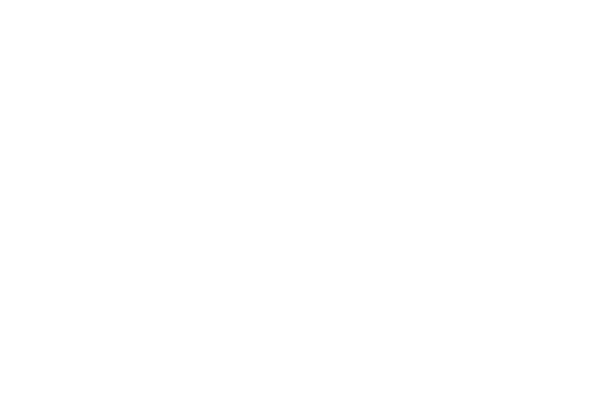

In [11]:
res = poisson_2d_lifting_example(Jmax=4)
U_num=res["u_num"]

xs = np.linspace(0, 1, U_num.shape[0])
ys = np.linspace(0, 1, U_num.shape[1])
X, Y = np.meshgrid(xs, ys, indexing="ij")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, U_num, cmap="viridis", linewidth=0, antialiased=True)
ax.set_title("2D Poisson solution (Galerkin, Kronecker)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import copy
import sympy as sp
from src.operators import differentiate
from src.matrix_generation.matrix_generation import assemble_matrix_integral_1d, extend_stiffness

def poisson_2d_lifting_general(
    f_expr, g_expr,
    Jmax=4,
    xs_ref=np.linspace(0, 1, 128),
    ys_ref=np.linspace(0, 1, 128)
):
    """
    Solve -Δu = f on (0,1)^2 with Dirichlet BC u=g using lifting:
        u = u_h + u_g, where u_h|∂Ω = 0 and -Δu_h = f + Δu_g.

    Parameters
    ----------
    f_expr : sympy expression or callable
        Right-hand side f(x,y)
    g_expr : sympy expression or callable
        Boundary data g(x,y)
    Jmax : int
        Finest level for the wavelet-Galerkin discretization
    xs_ref, ys_ref : ndarray
        Reference grids for evaluation and error computation
    """

    # === symbolic setup ===
    x, y = sp.symbols('x y', real=True)
    if not isinstance(g_expr, sp.Expr):
        g_expr = g_expr(x, y)
    if not isinstance(f_expr, sp.Expr):
        f_expr = f_expr(x, y)

    # lifting function u_g(x,y)
    u_g_expr = g_expr

    # compute Laplacian Δu_g symbolically
    lap_u_g_expr = sp.diff(u_g_expr, x, 2) + sp.diff(u_g_expr, y, 2)

    # convert to fast numerical functions
    u_g_func = sp.lambdify((x, y), u_g_expr, "numpy")
    lap_u_g_func = sp.lambdify((x, y), lap_u_g_expr, "numpy")
    f_rhs_func = sp.lambdify((x, y), f_expr, "numpy")

    # effective RHS for the homogeneous problem (f_eff = f + Δu_g)
    def f_eff_func(xv, yv):
        return f_rhs_func(xv, yv) + lap_u_g_func(xv, yv)

    # === build wavelet bases and matrices ===
    basis_handler.build_basis(J_Max=Jmax, comp_call=True, J_0=2)
    basis_handler_diff = copy.deepcopy(basis_handler)
    basis_handler_diff.apply(differentiate, comp_call=True, axis=0)

    Phi_1d = basis_handler.flatten()
    DPhi_1d = basis_handler_diff.flatten()

    M1 = assemble_matrix_integral_1d(Phi_1d, Phi_1d)
    S1 = assemble_matrix_integral_1d(DPhi_1d, DPhi_1d)
    S2 = extend_stiffness(M1, S1, 2)

    # === project the effective RHS and solve for u_h ===
    b2 = basis_handler.project_rhs_2d_gauss(f_eff_func)
    coeffs = solve_precond(S2, b2)
    N1 = len(Phi_1d)
    C = coeffs.reshape(N1, N1)

    # === evaluate basis on reference nodes ===
    Phix    = basis_handler._eval_basis_on_nodes(Phi_1d, xs_ref)
    Phiy    = basis_handler._eval_basis_on_nodes(Phi_1d, ys_ref)
    Phix_dx = basis_handler._eval_basis_on_nodes(DPhi_1d, xs_ref)
    Phiy_dy = basis_handler._eval_basis_on_nodes(DPhi_1d, ys_ref)

    X, Y = np.meshgrid(xs_ref, ys_ref, indexing="ij")

    # === evaluate u_h, gradients, and total u ===
    u_h_num   = Phix    @ C @ Phiy.T
    u_h_num_x = Phix_dx @ C @ Phiy.T
    u_h_num_y = Phix    @ C @ Phiy_dy.T

    u_num   = u_h_num + u_g_func(X, Y)
    u_num_x = u_h_num_x + sp.lambdify((x, y), sp.diff(u_g_expr, x), "numpy")(X, Y)
    u_num_y = u_h_num_y + sp.lambdify((x, y), sp.diff(u_g_expr, y), "numpy")(X, Y)

    # === optional reference (if available) ===
    u_ref = u_num  # placeholder if no analytic sol
    err_L2 = np.nan
    err_H1 = np.nan

    print(f"[Lifting Poisson 2D general]  J={Jmax} completed.")
    return {
        "Jmax": Jmax,
        "u_num": u_num,
        "u_num_x": u_num_x,
        "u_num_y": u_num_y,
        "C": C,
        "S2": S2,
        "u_g": u_g_func,
        "lap_u_g": lap_u_g_func,
        "errors": {"L2": err_L2, "H1": err_H1},
    }


5
[Lifting Poisson 2D general]  J=4 completed.
Errors : {'L2': nan, 'H1': nan}


/var/folders/p2/0kkgqlf96hvb0wqg1hjqnj600000gn/T/ipykernel_16977/522626165.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


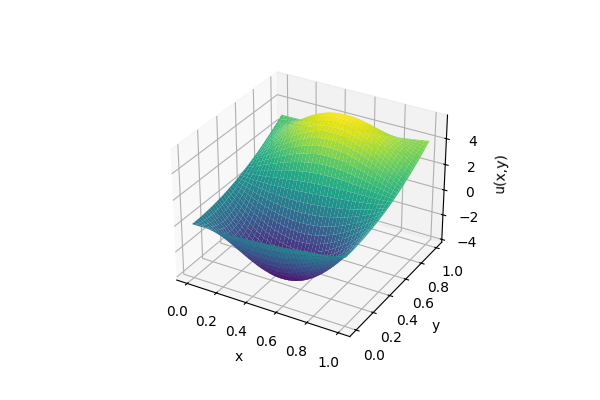

In [19]:
x, y = sp.symbols('x y')


# f_expr = 2*sp.pi**2 * sp.sin(sp.pi*x) * sp.sin(sp.pi*y)
# g_expr = 0.5*x**2 + 0.5*y**2   # smooth, nonhomogeneous boundary

u_exact_expr = x**2 + 3*y**2 - 2*sp.sin(sp.pi*x)*sp.sin(2*sp.pi*y)
f_expr = -sp.diff(u_exact_expr, x, 2) - sp.diff(u_exact_expr, y, 2)
g_expr = u_exact_expr  # restrictions handled implicitly on boundary

# u_exact_expr = sp.exp(x)*sp.cos(sp.pi*y)
# f_expr = -sp.diff(u_exact_expr, x, 2) - sp.diff(u_exact_expr, y, 2)
# g_expr = u_exact_expr
res = poisson_2d_lifting_general(f_expr, g_expr, Jmax=4)

U_num=res["u_num"]
print(f"Errors : {res["errors"]}")

xs = np.linspace(0, 1, U_num.shape[0])
ys = np.linspace(0, 1, U_num.shape[1])
X, Y = np.meshgrid(xs, ys, indexing="ij")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, U_num, cmap="viridis", linewidth=0, antialiased=True)
# ax.set_title("2D Poisson solution (Galerkin, Kronecker)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
plt.tight_layout()
plt.show()